# Laporan Bayesian Sampling

Nama  : Alif As'ad Ramadhan

NRP   : 5054231007

In [2]:
# Import wanring untuk mengabaikan Warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
from probability import *
from utils import print_table
from notebook import psource, pseudocode, heatmap

## Approximate Inference in Bayesian Networks

Inferensi eksak tidak efektif untuk diterapkan pada Bayesian Networks yang sangat besar dan kompleks. Bagian ini membahas implementasi algoritma sampling acak, yang juga dikenal sebagai algoritma `Monte Carlo`.

In [11]:
psource(BayesNode.sample)

In [100]:
def sample(self, event):
        """Sample from the distribution for this variable conditioned
        on event's values for parent_variables. That is, return True/False
        at random according with the conditional probability given the
        parents."""
        return probability(self.p(True, event))

Sebelum membahas berbagai algoritma pada bagian ini, mari kita tinjau metode **`BayesNode.sample`**. Metode ini melakukan sampling dari distribusi variabel yang dikondisikan oleh nilai-nilai *event* untuk variabel orang tua (*parent_variables*). Dengan kata lain, metode ini mengembalikan nilai *True* atau *False* secara acak sesuai dengan probabilitas kondisional yang diberikan oleh *parent*. Fungsi **`probability`** adalah fungsi pembantu sederhana dari modul *utils* yang mengembalikan *True* berdasarkan probabilitas yang diberikan kepadanya.


### Prior Sampling  

Ide dari *Prior Sampling* adalah untuk mengambil sampel dari *Bayesian Network* dalam urutan topologis. Kita memulai dari bagian atas jaringan dan melakukan sampling sesuai dengan **P(Xi | parents(Xi)**, yaitu distribusi probabilitas dari mana nilai tersebut diambil sebagai sampel dikondisikan pada nilai-nilai yang telah ditetapkan untuk *parent_variables*. Proses ini dapat dianggap sebagai simulasi.


In [17]:
psource(prior_sample)

In [102]:
def prior_sample(bn):
    """
    [Figure 14.13]
    Randomly sample from bn's full joint distribution.
    The result is a {variable: value} dict.
    """
    event = {}
    for node in bn.nodes:
        event[node.variable] = node.sample(event)
    return event

Fungsi *prior_sample* mengimplementasikan algoritma yang dijelaskan dalam Gambar 14.13 dari buku. Setiap node diambil sampel dalam urutan topologis. Nilai lama dari event digunakan sebagai bukti untuk nilai-nilai *parent_variables*. Kita akan menggunakan **Bayesian Network** pada Gambar untuk menguji fungsi *prior_sample*.


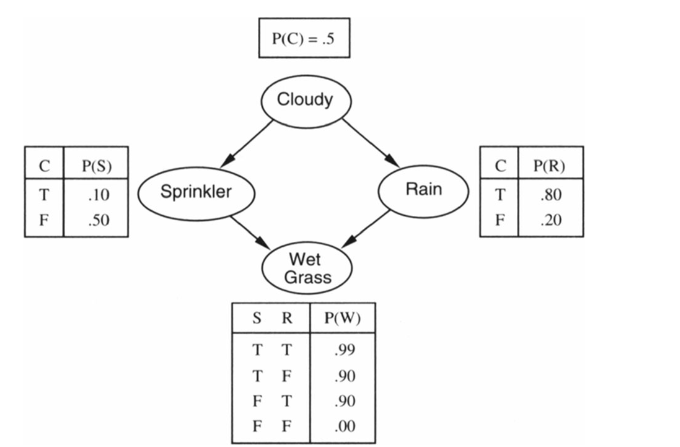

#### Penjelasan Gambar

Gambar di atas menunjukkan jaringan Bayesian dengan node `Cloudy`, `Sprinkler`, `Rain`, dan `Wet Grass`.

Diagram ini mencakup:

- Sebuah node bernama `Cloudy` yang memiliki probabilitas 0.5.
- Node `Sprinkler` dan `Rain` yang bergantung pada node `Cloudy`, dengan probabilitas masing-masing 0.10/0.50 untuk `Sprinkler` dan 0.80/0.20 untuk `Rain`.
- Node terakhir, `Wet Grass`, bergantung pada nilai dari `Sprinkler` dan `Rain`, dengan tabel probabilitas terperinci sesuai dengan nilai kedua variabel ini.

Urutan topologis dalam grafik sangat penting. Ada dua urutan topologis yang mungkin untuk grafik asiklik terarah ini:

1. `Cloudy` -> `Sprinkler` -> `Rain` -> `Wet Grass`
2. `Cloudy` -> `Rain` -> `Sprinkler` -> `Wet Grass`

Kita dapat menggunakan fungsi **`prior_sample`** untuk menghitung probabilitas dari berbagai kondisi dalam jaringan Bayesian. Misalnya, dengan mengambil 1000 sampel acak, kita dapat memperkirakan **P(Rain=True)** atau probabilitas bahwa **Rain** terjadi dalam kondisi yang diberikan. Proses ini melibatkan pengambilan sampel dari jaringan berkali-kali dan menghitung proporsi sampel di mana **Rain=True**.

Sampling prior ini berguna sebagai teknik simulasi untuk menghitung probabilitas kejadian tanpa melakukan perhitungan eksak yang mungkin kompleks dan tidak efisien untuk jaringan yang lebih besar. Metode ini memungkinkan kita mengestimasi probabilitas kejadian berdasarkan hubungan antar-node dalam jaringan Bayesian.



In [28]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]

Sekarang kita melakukan pemfilteran untuk mendapatkan observasi di mana `Rain = True`.

In [31]:
rain_true = [observation for observation in all_observations if observation['Rain'] == True]

In [33]:
answer = len(rain_true) / N
print(answer)

0.5


Melakukan pengambilan sampel ini sekali lagi mungkin memberikan hasil yang berbeda karena kita tidak memiliki kendali atas distribusi sampel acak

In [36]:
N = 1000
all_observations = [prior_sample(sprinkler) for x in range(N)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
answer = len(rain_true) / N
print(answer)

0.533


#### Evaluasi Distribusi Kondisional

Untuk mengevaluasi distribusi kondisional, kita dapat menggunakan proses penyaringan dua langkah. Pertama, kita memisahkan variabel-variabel yang konsisten dengan bukti yang ada. Kemudian, untuk setiap nilai dari variabel query, kita dapat menemukan probabilitasnya. Sebagai contoh, untuk menemukan 
`P(Cloudy=True∣Rain=True)`. Kita telah menyaring nilai-nilai yang konsisten dengan bukti kita dalam rain_true. Sekarang kita menerapkan langkah penyaringan kedua pada rain_true untuk menemukan 
`P(Rain=True and Cloudy=True)`.

In [42]:
rain_and_cloudy = [observation for observation in rain_true if observation['Cloudy'] == True]
answer = len(rain_and_cloudy) / len(rain_true)
print(answer)

0.8030018761726079


### Rejection Sampling

Rejection Sampling didasarkan pada ide yang mirip dengan yang baru saja kita lakukan. Pertama, metode ini menghasilkan sampel dari distribusi prior yang ditentukan oleh jaringan. Kemudian, ia menolak semua sampel yang tidak sesuai dengan bukti yang ada.

Rejection sampling hanya menguntungkan jika kita sudah mengetahui query sebelumnya. Sementara prior sampling umumnya berfungsi untuk semua query, metode ini bisa gagal dalam beberapa situasi.

Misalkan kita memiliki jaringan Bayesian umum dan terdapat bukti ( e ), serta kita ingin mengetahui berapa kali suatu keadaan ( A ) benar, mengingat bukti ( e ) benar. Biasanya, prior sampling dapat menjawab pertanyaan ini, tetapi anggaplah probabilitas ( e ) benar dalam distribusi probabilitas kita sangat kecil. Dalam situasi ini, mungkin saja proses sampling tidak pernah menemukan data di mana ( e ) benar. Jika data sampel kita tidak memiliki instance di mana ( e ) benar, maka ( P(e) = 0 ), dan oleh karena itu ( P(A | e) / P(e) = 0 ), yang tidak terdefinisi. Kita tidak dapat menemukan nilai yang diperlukan menggunakan sampel ini.

Kita dapat meningkatkan jumlah titik sampel, tetapi kita tidak pernah dapat menjamin bahwa kita akan menemukan kasus di mana  e adalah `non-zero`  (dengan asumsi bahwa dalam distribusi probabilitas sebenarnya, terdapat setidaknya satu kasus di mana ( e ) benar). Untuk menjamin hal ini, kita harus mempertimbangkan setiap titik data, yang berarti kita kehilangan keunggulan kecepatan yang diberikan oleh pendekatan aproksimasi dan pada dasarnya harus menghitung model inferensi tepat dari jaringan Bayesian.

Rejection sampling akan berguna dalam situasi ini, karena kita sudah mengetahui query-nya. Saat melakukan sampling dari jaringan, kita akan menolak sampel apa pun yang tidak konsisten dengan variabel bukti dari query yang diberikan (dalam contoh ini, satu-satunya variabel bukti adalah ( e ). Kita hanya akan mempertimbangkan sampel yang tidak melanggar variabel bukti apa pun. Dengan cara ini, kita akan memiliki cukup data dengan bukti yang diperlukan untuk melakukan inferensi query yang melibatkan subset dari bukti tersebut.

Fungsi `rejection_sampling` mengimplementasikan algoritma yang dijelaskan oleh Gambar 14.14.


In [48]:
psource(rejection_sampling)

In [104]:
def rejection_sampling(X, e, bn, N=10000):
    """
    [Figure 14.14]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn, using N samples.
    Raises a ZeroDivisionError if all the N samples are rejected,
    i.e., inconsistent with e.
    >>> random.seed(47)
    >>> rejection_sampling('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.7, True: 0.3'
    """
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.14]
    for j in range(N):
        sample = prior_sample(bn)  # boldface x in [Figure 14.14]
        if consistent_with(sample, e):
            counts[sample[X]] += 1
    return ProbDist(X, counts)

Fungsi ini menyimpan hitungan untuk setiap nilai yang mungkin dari variabel Query dan meningkatkan hitungan ketika kita melihat observasi yang konsisten dengan bukti. Fungsi ini menerima parameter input X - Variabel Query, e - bukti, bn - jaringan Bayes, dan N - jumlah sampel prior yang akan dihasilkan.

**consistent_with** digunakan untuk memeriksa konsistensi.








In [53]:
psource(consistent_with)

In [106]:
def consistent_with(event, evidence):
    """Is event consistent with the given evidence?"""
    return all(evidence.get(k, v) == v for k, v in event.items())

Untuk menjawab **P(Cloudy=True | Rain=True)**

In [56]:
p = rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)
p[True]

0.8071570576540755

### Likelihood Weighting

Rejection sampling memerlukan waktu yang lama ketika probabilitas untuk menemukan bukti yang konsisten rendah. Metode ini juga lambat untuk jaringan yang lebih besar dan variabel bukti yang lebih banyak. Rejection sampling cenderung menolak banyak sampel jika bukti kita terdiri dari sejumlah besar variabel. Likelihood Weighting menyelesaikan masalah ini dengan menetapkan nilai tetap untuk bukti (yaitu, tidak melakukan sampling untuk variabel bukti) dan kemudian menggunakan bobot untuk memastikan bahwa keseluruhan sampling kita tetap konsisten.

Pseudocode pada Gambar 14.15 diimplementasikan dalam `likelihood_weighting` dan `weighted_sample`.


In [63]:
psource(weighted_sample)

In [108]:
def weighted_sample(bn, e):
    """
    Sample an event from bn that's consistent with the evidence e;
    return the event and its weight, the likelihood that the event
    accords to the evidence.
    """
    w = 1
    event = dict(e)  # boldface x in [Figure 14.15]
    for node in bn.nodes:
        Xi = node.variable
        if Xi in e:
            w *= node.p(e[Xi], event)
        else:
            event[Xi] = node.sample(event)
    return event, w

Fungsi weighted_sample adalah bagian dari metode Likelihood Weighting untuk inferensi pada jaringan Bayesian. Metode ini berfungsi untuk menghasilkan sebuah event (kejadian) yang konsisten dengan bukti yang diberikan, serta menghitung bobot (weight) yang menunjukkan seberapa besar kemungkinan event tersebut sesuai dengan bukti.

**Penjelasan Fungsi `weighted_sample`**

Parameter:

`bn`: Objek jaringan Bayesian (`Bayesian Network`) yang berisi struktur dan parameter probabilitas dari jaringan tersebut.

`e`: Sebuah dictionary yang merepresentasikan bukti (`evidence`) dalam bentuk pasangan variabel dan nilai yang diketahui benar.

Langkah Kerja:

- Inisialisasi Weight: Fungsi memulai dengan menginisialisasi w = 1, yang akan digunakan untuk menghitung bobot total.

- Inisialisasi Event: Variabel event diinisialisasi sebagai salinan dari bukti e. Ini berarti nilai-nilai bukti langsung diatur pada event di awal.

- Iterasi Pada Node Jaringan:

    1. Untuk setiap node dalam jaringan, jika variabel tersebut termasuk dalam bukti e, maka w dikalikan dengan probabilitas node tersebut berdasarkan bukti (P(e[X_i] | parents(X_i))).

    2. Jika variabel tidak terdapat dalam bukti, maka nilai variabel tersebut disampling menggunakan metode sample(event).

- Return Event dan Weight: Fungsi mengembalikan event yang berisi semua nilai variabel (termasuk yang disampling) dan w sebagai bobot total.

In [69]:
weighted_sample(sprinkler, dict(Rain=True))

({'Rain': True, 'Cloudy': True, 'Sprinkler': False, 'WetGrass': True}, 0.8)

Pada contoh penggunaan `weighted_sample(sprinkler, dict(Rain=True))`, fungsi ini dipanggil dengan:

sprinkler sebagai `Bayesian Networks`.

`e = {'Rain': True}` sebagai bukti.

Hasilnya adalah sebuah event dengan nilai-nilai variabel dalam jaringan yang konsisten dengan `Rain=True`, serta `bobot 0.2`, yang merepresentasikan tingkat konsistensi event tersebut dengan bukti yang diberikan.

In [72]:
psource(likelihood_weighting)

In [110]:
def likelihood_weighting(X, e, bn, N=10000):
    """
    [Figure 14.15]
    Estimate the probability distribution of variable X given
    evidence e in BayesNet bn.
    >>> random.seed(1017)
    >>> likelihood_weighting('Burglary', dict(JohnCalls=T, MaryCalls=T),
    ...   burglary, 10000).show_approx()
    'False: 0.702, True: 0.298'
    """
    W = {x: 0 for x in bn.variable_values(X)}
    for j in range(N):
        sample, weight = weighted_sample(bn, e)  # boldface x, w in [Figure 14.15]
        W[sample[X]] += weight
    return ProbDist(X, W)

Fungsi likelihood_weighting adalah implementasi dari metode Likelihood Weighting untuk menyelesaikan masalah inferensi pada jaringan Bayesian. Metode ini memperkirakan distribusi probabilitas dari variabel target 
X, mengingat bukti 
e dalam jaringan Bayesian bn.

**Penjelasan Fungsi `likelihood_weighting`**

**Parameter:**

- `X`: Variabel query yang probabilitasnya ingin kita hitung.

- `e`: Bukti (evidence) dalam bentuk dictionary, yang mengandung pasangan variabel dan nilai yang diketahui benar.

- `bn`: Jaringan Bayesian (BayesNet) yang berisi struktur dan parameter probabilitas.

- `N`: Jumlah sampel yang ingin diambil (default: 10,000).

**Langkah Ke**rja:
1. **Inisialisasi Weight Dictionary**: Membuat dictionary `W` yang akan menyimpan total bobot untuk setiap kemungkinan nilai dari variabel query `X`.

2. **Loop Pengambilan Sampel**:

   - Untuk setiap iterasi `j` hingga `N`, fungsi mengambil sampel `sample` dan bobot `weight` dari fungsi `weighted_sample(bn, e)`.

   - Bobot ini kemudian ditambahkan ke nilai yang sesuai dalam dictionary `W` untuk setiap nilai dari `sample[X]`.

4. **Return Distribusi Probabilitas**: Fungsi mengembalikan objek `ProbDist(X, W)` yang merepresentasikan distribusi probabilitas dari variabel query `X`.


In [80]:
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.197, True: 0.803'

Pada contoh `likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()`, fungsi `likelihood_weighting` dipanggil dengan:

- `X = 'Cloudy'` sebagai variabel query.

- `e = {'Rain': True}` sebagai bukti.

- `sprinkler` sebagai jaringan Bayesian.

- `N = 200`, yaitu jumlah sampel.

Hasilnya menunjukkan probabilitas dari `Cloudy` dengan kondisi `Rain=True`, yaitu:

- `False`: 0.2

- `True`: 0.8


### Gibbs Sampling

Dalam `likelihood sampling`, mungkin diperoleh bobot rendah pada kasus di mana variabel bukti terletak di bagian bawah *Bayesian Networks*. Hal ini bisa terjadi karena pengaruh hanya menyebar ke bawah dalam `likelihood sampling`.

Gibbs Sampling menyelesaikan hal ini. Implementasi dari Gambar 14.16 disediakan dalam fungsi gibbs_ask

In [85]:
psource(gibbs_ask)

In [112]:
def gibbs_ask(X, e, bn, N=1000):
    """[Figure 14.16]"""
    assert X not in e, "Query variable must be distinct from evidence"
    counts = {x: 0 for x in bn.variable_values(X)}  # bold N in [Figure 14.16]
    Z = [var for var in bn.variables if var not in e]
    state = dict(e)  # boldface x in [Figure 14.16]
    for Zi in Z:
        state[Zi] = random.choice(bn.variable_values(Zi))
    for j in range(N):
        for Zi in Z:
            state[Zi] = markov_blanket_sample(Zi, state, bn)
            counts[state[X]] += 1
    return ProbDist(X, counts)

Pada `gibbs_ask`, kita menginisialisasi variabel non-bukti dengan nilai acak. Kemudian, pilih variabel non-bukti dan ambil sampelnya dari `P(Variabel | nilai dalam keadaan saat ini dari semua variabel yang tersisa)` sampel berulang. Dalam praktiknya, kita mempercepat ini dengan menggunakan `markov_blanket_sample` sebagai gantinya. Ini berhasil karena istilah yang tidak melibatkan variabel dibatalkan dalam perhitungan. Argumen untuk `gibbs_ask` mirip dengan `likelihood_weighting`.

In [87]:
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200).show_approx()

'False: 0.215, True: 0.785'

### Runtime analysis

In [90]:
%%timeit
all_observations = [prior_sample(sprinkler) for x in range(1000)]
rain_true = [observation for observation in all_observations if observation['Rain'] == True]
len([observation for observation in rain_true if observation['Cloudy'] == True]) / len(rain_true)

3.25 ms ± 249 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [92]:
%%timeit
rejection_sampling('Cloudy', dict(Rain=True), sprinkler, 1000)

4.45 ms ± 371 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [94]:
%%timeit
likelihood_weighting('Cloudy', dict(Rain=True), sprinkler, 200)

743 μs ± 56.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [96]:
%%timeit
gibbs_ask('Cloudy', dict(Rain=True), sprinkler, 200)

23.9 ms ± 7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



Seperti yang diharapkan, semua algoritme memiliki waktu proses yang sangat mirip. Namun, **Rejection Sampling** akan jauh lebih cepat dan lebih akurat ketika probabilitas menemukan titik data yang konsisten dengan bukti yang dibutuhkan kecil. Pada kondisi tertentu, metode ini menjadi pilihan yang efisien meskipun terdapat proses penolakan sampel.

**Likelihood Weighting** merupakan metode yang paling cepat dari semuanya karena tidak melibatkan penolakan sampel. Namun, metode ini memiliki varians yang cukup tinggi, yang berarti bahwa hasilnya bisa lebih bervariasi dan kurang stabil dibandingkan metode lainnya. Meskipun demikian, untuk kasus tertentu yang tidak memerlukan akurasi tinggi, Likelihood Weighting bisa menjadi opsi yang sangat efektif.
